In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [5]:
df = pd.read_csv("./data_2000_2019.csv")

<h1>Removendo dados nulos</h1>

In [6]:
df = df.dropna(axis=0, how='any', subset=None, inplace=False)
print(df.shape)

(126996, 26)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 126996 entries, 6696 to 133919
Data columns (total 26 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   micro_code       126996 non-null  int64  
 1   micro_name       126996 non-null  object 
 2   micro_name_ibge  126996 non-null  object 
 3   meso_code        126996 non-null  int64  
 4   meso_name        126996 non-null  object 
 5   state_code       126996 non-null  int64  
 6   state_name       126996 non-null  object 
 7   region_code      126996 non-null  int64  
 8   region_name      126996 non-null  object 
 9   biome_code       126996 non-null  int64  
 10  biome_name       126996 non-null  object 
 11  ecozone_code     126996 non-null  int64  
 12  ecozone_name     126996 non-null  object 
 13  main_climate     126996 non-null  object 
 14  month            126996 non-null  int64  
 15  year             126996 non-null  int64  
 16  time             126996 non-null  int64 

<h1>Selecionando os atributos</h1>

In [8]:
df = df[['micro_code', 'state_code', 'region_code', 'biome_code', 'ecozone_code', 'main_climate', 'month', 'year', 'time', 'dengue_cases', 'population', 'pop_density', 'tmax', 'tmin', 'pdsi', 'urban', 'water_network', 'water_shortage']]

<p>Para essa parte da análise vamos utilizar os códigos presente no proprio dataframe ao invés dos nomes escritos. Então, por exemplo ao invés de usar o nome do estado vamos utilizar o código do estado assim para cidade, bioma, ecozona. O único atributo que vamos tratar será o 'main_climate' que está no formato texto.</p>

<h1>Definindo função para tratar atributos não numéricos utilizando o One Hot Enconder</h1>

In [9]:
def codDeAtributo(atributo, df):
    # Importando biblioteca OneHotEncoder da sklearn
    from sklearn.preprocessing import OneHotEncoder

    # Criando encoder sparse=false retorna um array denso, ao invés de uma matriz esparsa
    encoder = OneHotEncoder(sparse_output=False)

    # Ajustar e transformar os dados
    encoded_data = encoder.fit_transform(df[[atributo]])

    # Converter o resultado para um dataframe
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out([atributo]))
    #encoded_df.head()

    # Concatenando o dataframe original com o novo atributo regiao codificado
    df_machine = pd.concat([df.drop(atributo, axis=1), encoded_df], axis=1)
    return df_machine

<h1>Definindo função para plotagem do gráfico que analisará o desempenho do modelo</h1>

In [10]:
def analise_regressor(y_test, y_reg, x):
    y_test_sub = y_test[:x]
    y_reg_sub = y_reg[:x]

    plt.figure(figsize=(14,8))
    plt.plot(y_test_sub.values, label='Real', marker='o', linestyle='-', markersize=5)
    plt.plot(y_reg_sub, label='Previsto', marker='x', linestyle='-', markersize=5)
    plt.title('Comparação entre valores reais e previstos')
    plt.xlabel('Índice')
    plt.ylabel('Valores')
    plt.legend()
    plt.grid(True)
    plt.show()

In [11]:
df_codificado = codDeAtributo('main_climate', df)
df_codificado.head()

,micro_code,state_code,region_code,biome_code,ecozone_code,month,year,time,dengue_cases,population,...,water_shortage,main_climate_AF,main_climate_AM,main_climate_AS,main_climate_AW,main_climate_BSH,main_climate_CFA,main_climate_CFB,main_climate_CWA,main_climate_CWB
6696,11001.0,11.0,1.0,5.0,5.0,1.0,2001.0,13.0,267.0,426640.0,...,0.2245,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6697,11002.0,11.0,1.0,5.0,5.0,1.0,2001.0,13.0,12.0,61321.0,...,0.0873,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6698,11003.0,11.0,1.0,5.0,5.0,1.0,2001.0,13.0,2.0,143809.0,...,0.1871,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6699,11004.0,11.0,1.0,5.0,5.0,1.0,2001.0,13.0,93.0,306896.0,...,0.2381,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6700,11005.0,11.0,1.0,5.0,5.0,1.0,2001.0,13.0,1.0,74460.0,...,0.2837,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


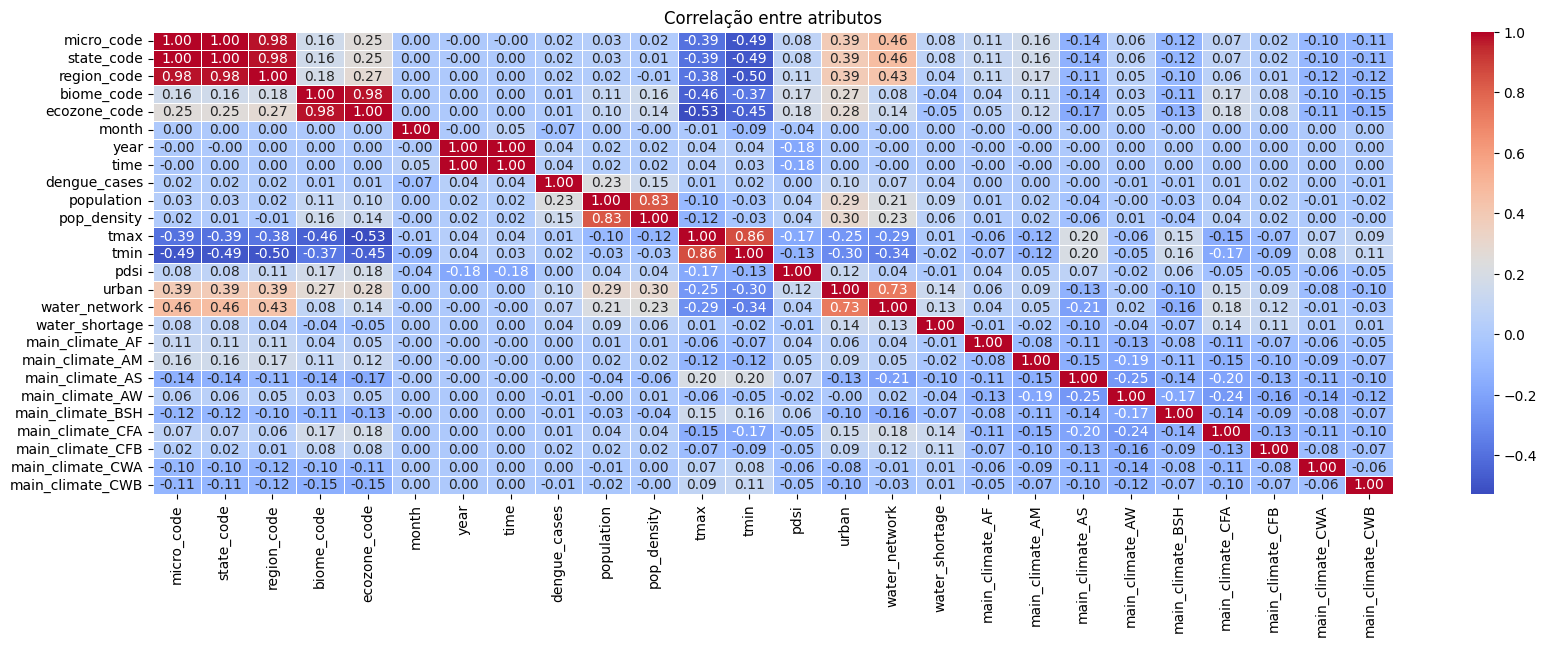

In [12]:
plt.figure(figsize=(20,6))
sns.heatmap(df_codificado.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Correlação entre atributos')
plt.show()

<h1>Removendo dados nulos</h1>

In [13]:
df_codificado = df_codificado.dropna()

<h1>Importando bibliotecas para separação do dataset e treinamento</h1>

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

<h1>Separando o data-set</h1>
<p> Removi das features o Label (coluna que queremos prever) em seguida é definido o Label e por fim separamos os dados em vinte por cento para teste e oitenta por cento para treino </p>

In [15]:
# Features ou variáveis independentes / excluindo a variável que quero prever que são os casos de dengue
X = df_codificado.drop(columns=['dengue_cases'])
# Label ou variável dependente, é o que queremos prever
y = df_codificado['dengue_cases']

# Separando os dados em treino e teste, selecionando 20% dos dados para teste, 80% para treino e definindo uma semente em 42 / 
#para garantir a reprodutibilidade do experimento
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<h1>Aplicando o Linear Regression</h1>

In [16]:
reg_model = LinearRegression()
reg_model.fit(x_train, y_train)
y_pred_reg = reg_model.predict(x_test)

<h1>Importando bibliotecas para análise do regressor</h1>

In [17]:
from sklearn.metrics import mean_squared_error,  mean_absolute_error, mean_absolute_percentage_error, accuracy_score

In [18]:
mse = mean_squared_error(y_test, y_pred_reg)
print("Erro quadrático médio (MSE) para regressão:", mse)

mae = mean_absolute_error(y_test, y_pred_reg)
print("Erro médio absoluto (MAE) para regressão:", mae)
3
mape = mean_absolute_percentage_error(y_test, y_pred_reg)
print("Erro médio percentual absoluto (MAPE) para regressão:", mape)

Erro quadrático médio (MSE) para regressão: 930797.769781887
Erro médio absoluto (MAE) para regressão: 156.32126993363545
Erro médio percentual absoluto (MAPE) para regressão: 9.608850889268517e+16


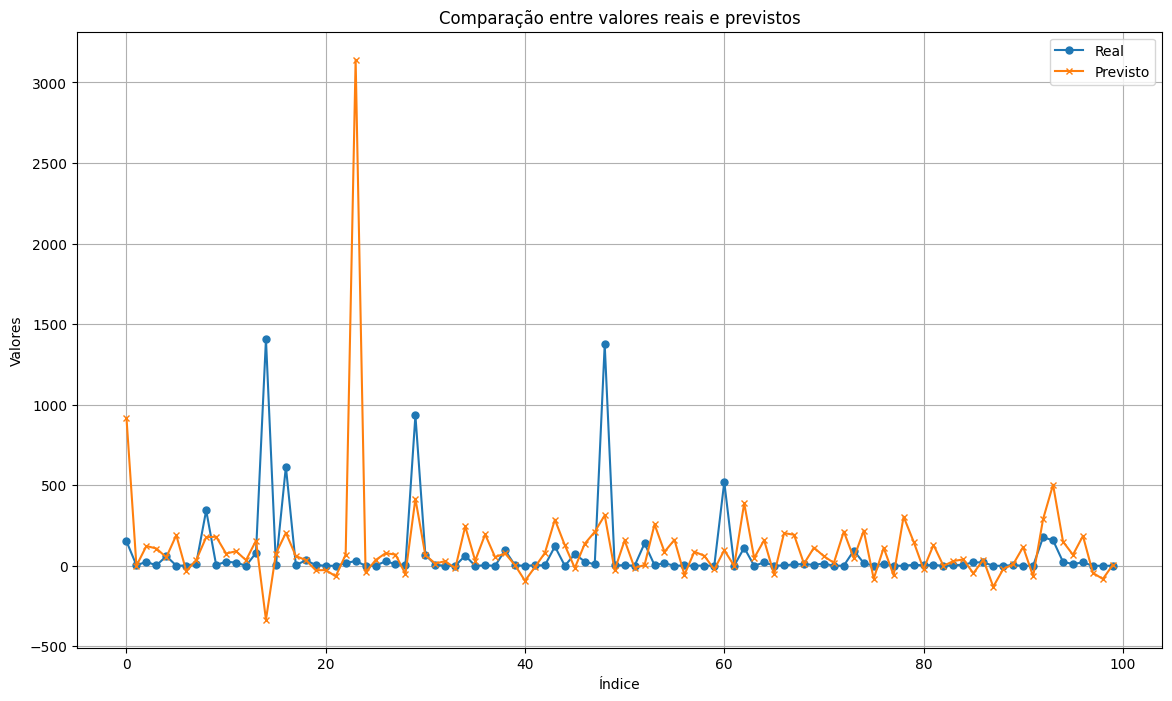

In [19]:
analise_regressor(y_test, y_pred_reg, 100)

<h1>KNN Regressor</h1>

In [20]:
from sklearn.neighbors import KNeighborsRegressor


reg_model_knn = KNeighborsRegressor(n_neighbors=5)
reg_model_knn.fit(x_train, y_train)
y_pred_reg_knn = reg_model_knn.predict(x_test)

In [27]:
mse = mean_squared_error(y_test, y_pred_reg_knn)
print("Erro quadrático médio (MSE) para regressão:", mse)

mae = mean_absolute_error(y_test, y_pred_reg_knn)
print("Erro médio absoluto (MAE) para regressão:", mae)
3
mape = mean_absolute_percentage_error(y_test, y_pred_reg_knn)
print("Erro médio percentual absoluto (MAPE) para regressão:", mape)

Erro quadrático médio (MSE) para regressão: 455226.8437823208
Erro médio absoluto (MAE) para regressão: 76.53227297331057
Erro médio percentual absoluto (MAPE) para regressão: 3411124654265593.0


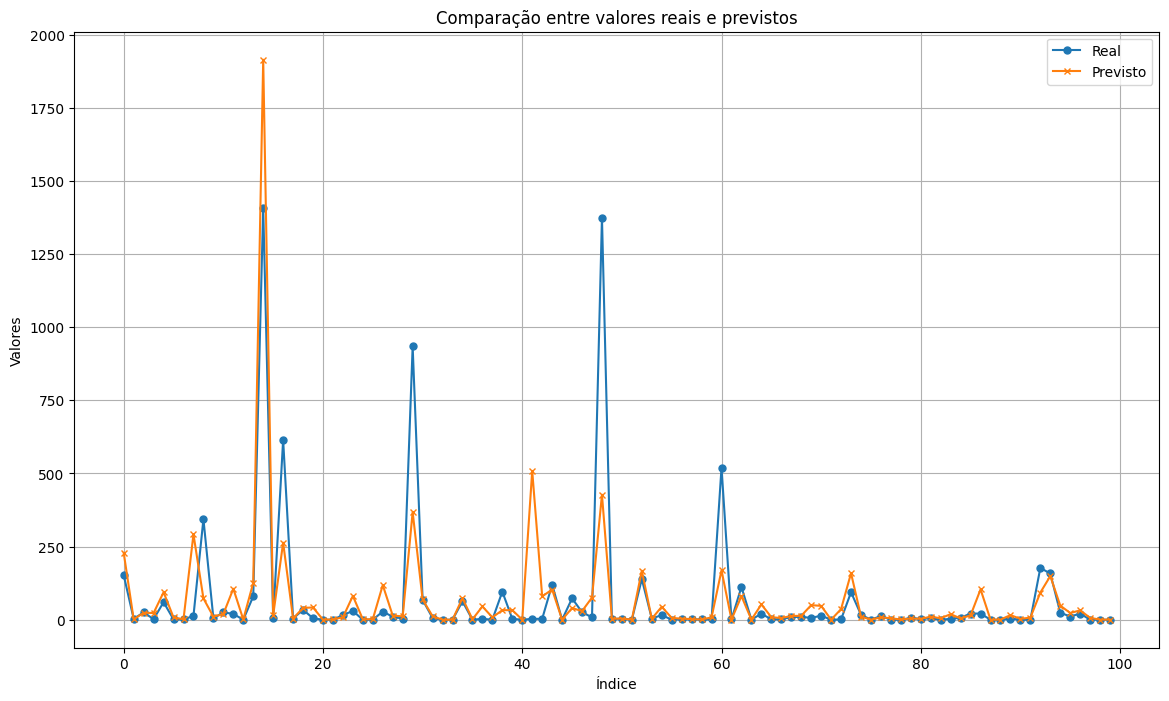

In [28]:
analise_regressor(y_test, y_pred_reg_knn, 100)

<h1>Decision Tree</h1>

In [29]:
from sklearn.tree import DecisionTreeRegressor

reg_model_dt = DecisionTreeRegressor()
reg_model_dt.fit(x_train, y_train)
y_pred_reg_dt = reg_model_dt.predict(x_test)

In [30]:
mse = mean_squared_error(y_test, y_pred_reg_dt)
print("Erro quadrático médio (MSE) para regressão:", mse)

mae = mean_absolute_error(y_test, y_pred_reg_dt)
print("Erro médio absoluto (MAE) para regressão:", mae)
3
mape = mean_absolute_percentage_error(y_test, y_pred_reg_dt)
print("Erro médio percentual absoluto (MAPE) para regressão:", mape)

Erro quadrático médio (MSE) para regressão: 1080251.0278969062
Erro médio absoluto (MAE) para regressão: 86.4635466544531
Erro médio percentual absoluto (MAPE) para regressão: 4808502529236028.0


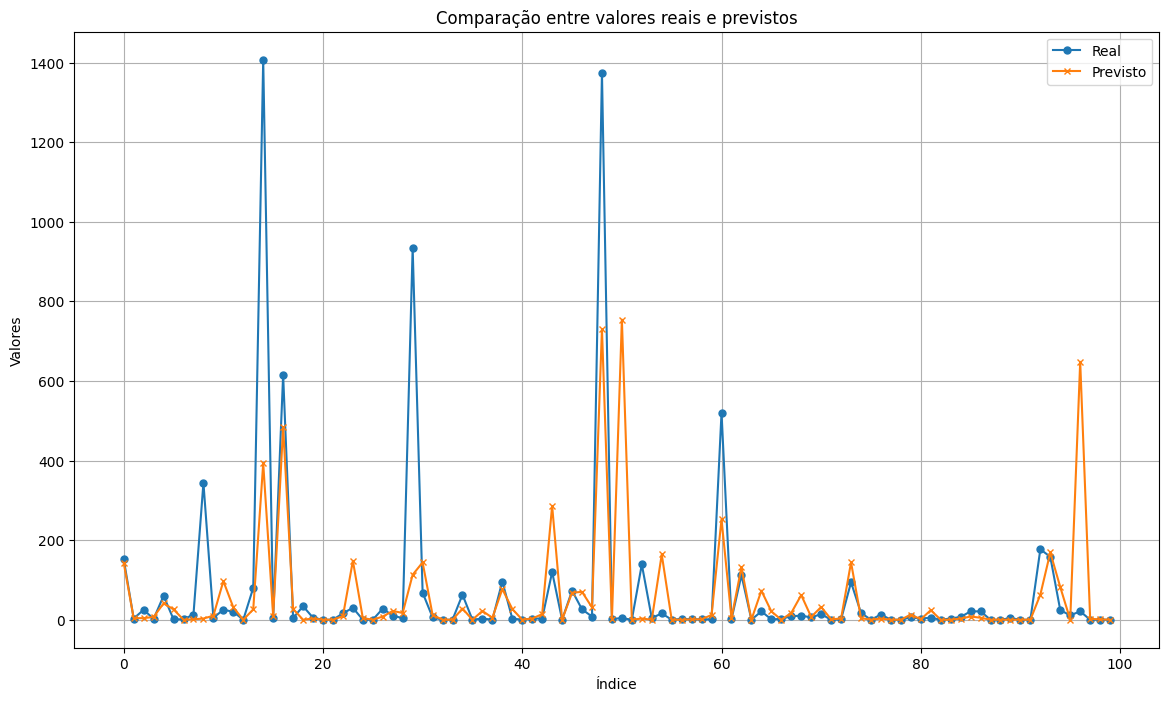

In [31]:
analise_regressor(y_test, y_pred_reg_dt, 100)

<h1>Random Forest Regressor</h1>

In [36]:
# Import de biblioteca necessária
from sklearn.ensemble import RandomForestRegressor

reg_model_rf = RandomForestRegressor(n_estimators=100)#n_estimators=10
reg_model_rf.fit(x_train, y_train)
y_pred_reg_rf = reg_model_rf.predict(x_test)

In [37]:
mse = mean_squared_error(y_test, y_pred_reg_rf)
print("Erro quadrático médio (MSE) para regressão:", mse)

mae = mean_absolute_error(y_test, y_pred_reg_rf)
print("Erro médio absoluto (MAE) para regressão:", mae)
3
mape = mean_absolute_percentage_error(y_test, y_pred_reg_rf)
print("Erro médio percentual absoluto (MAPE) para regressão:", mape)

Erro quadrático médio (MSE) para regressão: 500662.4185425699
Erro médio absoluto (MAE) para regressão: 75.62615605612692
Erro médio percentual absoluto (MAPE) para regressão: 6778852212234295.0
